# RTM — Pluvial Hazard v1 (ERA5-Land) ingestion + sanity

**Phase:** 1a (hazard ingestion)

**Goal:** Load `H_pluvial_v1_mm` (building-level), validate schema + coverage, join to `E_hat` exposure proxy, and export lightweight stats.

**Non-goals:** inference, outcomes, return periods.

## 0) Setup

- Assumes `Habnetic/data` is a sibling repo to `resilient-housing-bayes` (or `HABNETIC_DATA` is set).
- Hazard loader: `src/rtm/io_hazard.py`

In [3]:
from __future__ import annotations

from pathlib import Path
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Notebook runs from .../resilient-housing-bayes/notebooks
# Actual repo root is one level up.
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name.lower() == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

# sanity
assert (REPO_ROOT / "src").exists(), f"Expected src/ at repo root: {REPO_ROOT}"

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])

from src.rtm.io_hazard import load_rtm_pluvial_v1_buildings

OUT_DIR = REPO_ROOT / "outputs" / "rtm" / "hazards"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Outputs:", OUT_DIR)

Repo root: C:\Users\C.Price\Habnetic\resilient-housing-bayes
sys.path[0]: C:\Users\C.Price\Habnetic\resilient-housing-bayes
Outputs: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\hazards


## 1) Load hazard (building-level)

Expected schema:
- `bldg_id`
- `H_pluvial_v1_mm`

In [4]:
haz = load_rtm_pluvial_v1_buildings()
haz.head()

,bldg_id,H_pluvial_v1_mm
0,305012,25.422161
1,313960,25.418823
2,313263,25.423113
3,310491,25.424500
4,313127,25.423491


In [5]:
print("Rows:", len(haz))
print("Columns:", list(haz.columns))
print("bldg_id unique:", haz["bldg_id"].is_unique)
print("NaNs (H_pluvial_v1_mm):", int(haz["H_pluvial_v1_mm"].isna().sum()))

Rows: 221324
Columns: ['bldg_id', 'H_pluvial_v1_mm']
bldg_id unique: True
NaNs (H_pluvial_v1_mm): 0


## 2) Range sanity + distribution

In [6]:
h = haz["H_pluvial_v1_mm"].astype(float)

stats_h = {
    "n": int(len(h)),
    "min": float(h.min()),
    "p50": float(h.quantile(0.50)),
    "p95": float(h.quantile(0.95)),
    "max": float(h.max()),
    "mean": float(h.mean()),
    "std": float(h.std(ddof=1)),
}
stats_h

{'n': 221324,
 'min': 25.408161163330078,
 'p50': 25.643714904785156,
 'p95': 26.013592815399168,
 'max': 26.504924774169922,
 'mean': 25.668643700884974,
 'std': 0.19523953639485467}

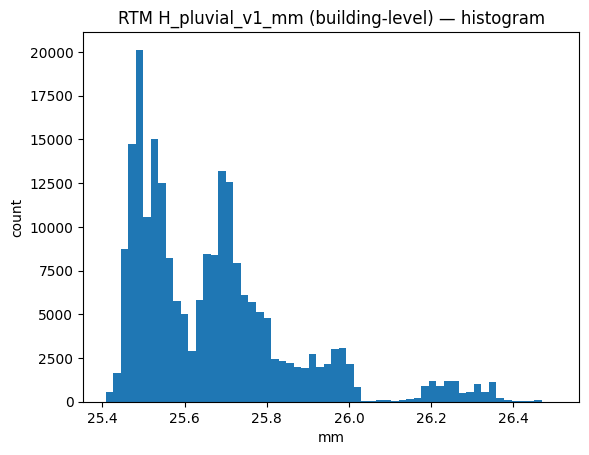

In [7]:
plt.figure()
plt.hist(h.values, bins=60)
plt.title("RTM H_pluvial_v1_mm (building-level) — histogram")
plt.xlabel("mm")
plt.ylabel("count")
plt.show()

## 3) Load exposure `E_hat` and join

Expected location (per Phase 0 outputs):
`outputs/rtm/water_exposure_Ehat_v0.parquet`

Expected columns:
- `bldg_id`
- `E_hat`

In [8]:
E_PATH = REPO_ROOT / "outputs" / "rtm" / "water_exposure_Ehat_v0.parquet"
if not E_PATH.exists():
    raise FileNotFoundError(
        f"Missing E_hat parquet at {E_PATH}.\n"
        "If you moved artifacts, update E_PATH in this notebook."
    )

E = pd.read_parquet(E_PATH)

if "E_hat" not in E.columns:
    candidates = [c for c in E.columns if c.lower() in {"ehat", "e_hat", "water_exposure_ehat", "exposure"}]
    if candidates:
        E = E.rename(columns={candidates[0]: "E_hat"})
    else:
        raise ValueError(f"Could not find E_hat column in: {list(E.columns)}")

if "bldg_id" not in E.columns:
    raise ValueError(f"E_hat parquet missing bldg_id. Columns: {list(E.columns)}")

E = E[["bldg_id", "E_hat"]].copy()

print("E rows:", len(E))
print("E bldg_id unique:", E["bldg_id"].is_unique)
E.head()

E rows: 221324
E bldg_id unique: True


,bldg_id,E_hat
0,305012,0.536838
1,313960,0.677579
2,313263,0.251841
3,310491,0.189019
4,313127,-0.292821


In [9]:
df = E.merge(haz, on="bldg_id", how="inner", validate="one_to_one")
print("Joined rows:", len(df))
print("Drops vs E:", len(E) - len(df))
print("Drops vs hazard:", len(haz) - len(df))
df.head()

Joined rows: 221324
Drops vs E: 0
Drops vs hazard: 0


,bldg_id,E_hat,H_pluvial_v1_mm
0,305012,0.536838,25.422161
1,313960,0.677579,25.418823
2,313263,0.251841,25.423113
3,310491,0.189019,25.424500
4,313127,-0.292821,25.423491


## 4) Relationship sanity: correlation + scatter (sample)

Expectation:
- Not perfectly correlated.
- Weak-to-moderate relationship at most.

In [10]:
corr = float(df[["E_hat", "H_pluvial_v1_mm"]].corr().iloc[0, 1])
corr

0.09079005368048573

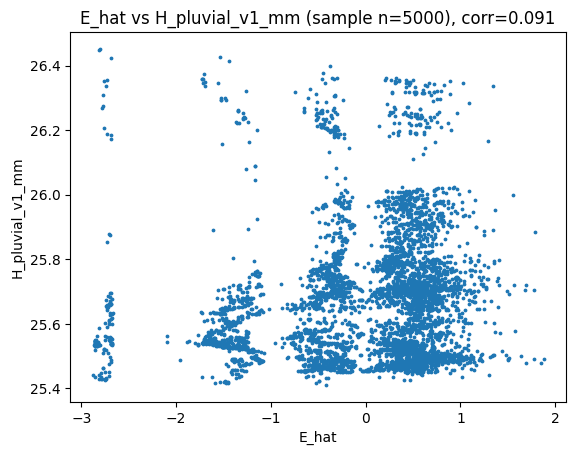

In [11]:
n = len(df)
sample_n = 5000 if n > 5000 else n
s = df.sample(sample_n, random_state=42)

plt.figure()
plt.scatter(s["E_hat"].values, s["H_pluvial_v1_mm"].values, s=3)
plt.title(f"E_hat vs H_pluvial_v1_mm (sample n={sample_n}), corr={corr:.3f}")
plt.xlabel("E_hat")
plt.ylabel("H_pluvial_v1_mm")
plt.show()

## 5) Export lightweight stats artifact

This is not a report. It’s a reproducibility breadcrumb.

In [12]:
artifact = {
    "hazard": {
        "name": "H_pluvial_v1",
        "metric": "mean_annual_max_1h_1991_2020",
        "units": "mm",
        "stats": stats_h,
    },
    "join": {
        "rows": int(len(df)),
        "corr_Ehat_H": corr,
    },
    "inputs": {
        "E_hat_path": str(E_PATH.as_posix()),
        "hazard_loader": "src.rtm.io_hazard.load_rtm_pluvial_v1_buildings",
    },
}

out_json = OUT_DIR / "rtm_pluvial_v1_ingestion_stats.json"
out_md = OUT_DIR / "rtm_pluvial_v1_ingestion_stats.md"

out_json.write_text(json.dumps(artifact, indent=2), encoding="utf-8")

md = [
    "# RTM pluvial hazard v1 ingestion stats\n\n",
    f"- rows: {artifact['join']['rows']}\n",
    f"- corr(E_hat, H_pluvial_v1_mm): {artifact['join']['corr_Ehat_H']:.3f}\n\n",
    "## Hazard summary (mm)\n\n",
    f"- min: {stats_h['min']:.3f}\n",
    f"- p50: {stats_h['p50']:.3f}\n",
    f"- p95: {stats_h['p95']:.3f}\n",
    f"- max: {stats_h['max']:.3f}\n",
    f"- mean: {stats_h['mean']:.3f}\n",
    f"- std: {stats_h['std']:.3f}\n\n",
    "## Inputs\n\n",
    f"- E_hat: `{artifact['inputs']['E_hat_path']}`\n",
    f"- hazard loader: `{artifact['inputs']['hazard_loader']}`\n",
]
out_md.write_text("".join(md), encoding="utf-8")

print("Wrote:")
print(" -", out_json)
print(" -", out_md)

Wrote:
 - C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\hazards\rtm_pluvial_v1_ingestion_stats.json
 - C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\hazards\rtm_pluvial_v1_ingestion_stats.md
